In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt; plt.rc('font', size=12)
import matplotlib.cm as cm
import seaborn as sns
from scipy.stats import entropy
from scipy.stats import percentileofscore
from scipy.spatial.distance import jensenshannon

In [2]:
taxa = ['B_caccae',
        'B_cellulosilyticus_WH2',
        'B_ovatus',
        'B_thetaiotaomicron',
        'B_uniformis',
        'B_vulgatus',
        'C_aerofaciens',
        'C_scindens',
        'C_spiroforme',
        # 'D_longicatena',
        'P_distasonis',
        'R_obeum'
        ]

pretty_names_dir = {'B_caccae': '$B. caccae$',
                'B_cellulosilyticus_WH2': '$B. cellulosilyticus$',
                'B_ovatus': '$B. ovatus$',
                'B_thetaiotaomicron': '$B. thetaiotaomicron$',
                'B_uniformis': '$B. uniformis$',
                'B_vulgatus': '$B. vulgatus$',
                'C_aerofaciens': '$C. aerofaciens$',
                'C_scindens': '$C. scindens$',
                'C_spiroforme': '$C. spiroforme$',
                # 'D_longicatena': '$D. longicatena$',
                'P_distasonis': '$P. distasonis$',
                'R_obeum': '$R. obeum$'
                }

abbr_names_dir = {'B_caccae': 'Bca',
                'B_cellulosilyticus_WH2': 'Bce',
                'B_ovatus': 'Bov',
                'B_thetaiotaomicron': 'Bth',
                'B_uniformis': 'Bun',
                'B_vulgatus': 'Bvu',
                'C_aerofaciens': 'Cae',
                'C_scindens': 'Csc',
                'C_spiroforme': 'Csp',
                # 'D_longicatena': 'Dlo',
                'P_distasonis': 'Pdi',
                'R_obeum': 'Rob'
                }

pretty_names = [pretty_names_dir[taxa] for taxa in taxa]

In [3]:
order_hm = ['Bce', 'Bov', 'Bth', 'Bvu', 'Bun', 'Bca', 'Pdi', 'Csc', 'Rob', 'Csp', 'Cae']

## Transformación de las matrices de interacción

In [4]:
def mask_by_bayes(interactions, inter_bayes):
    inter_bayes = inter_bayes.copy()
    interactions = interactions.copy()

    inter_bayes_mask = inter_bayes > np.sqrt(10)
    inter_bayes_mask = inter_bayes_mask.values
    
    interactions_matrix = interactions.values
    interactions_masked = np.ma.masked_array(interactions_matrix, mask=~inter_bayes_mask)
    interactions_masked = interactions_masked.filled(np.nan)
    return interactions_masked

def get_smallest_order_of_magnitude(x):
    return int(np.floor(np.log10(np.nanmin(np.abs(x)))))

# def max_min_swap(x):
#     x = x.copy()
#     x_min = np.nanmin(x)
#     x_max = np.nanmax(x)
#     for i in range(x.shape[0]):
#         for j in range(x.shape[1]):
#             if np.isnan(x[i,j]):
#                 continue
#             x[i,j] = x_max + x_min - x[i,j]
#     return x

# def tranform_interaction_matrix(interactions, inter_bayes):
#     interactions_masked = mask_by_bayes(interactions, inter_bayes)
#     transformed_interaction_matrix = max_min_swap(np.absolute(np.log10(np.absolute(interactions_masked)))) * np.sign(interactions_masked)
#     return transformed_interaction_matrix

def tranform_interaction_matrix(interactions, inter_bayes):
    interactions_masked = mask_by_bayes(interactions, inter_bayes)
    smallest_order_of_magnitude = get_smallest_order_of_magnitude(interactions_masked)
    transformed_interaction_matrix = np.log10(np.abs(interactions_masked * 10**(-1*smallest_order_of_magnitude))) * np.sign(interactions_masked)
    return transformed_interaction_matrix

def shift_to_positive(x):
    x = x.copy()
    C = np.absolute(np.nanmin(x)) + 0.1
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            if np.isnan(x[i,j]):
                x[i,j] = 0
            else:
                x[i,j] = x[i,j] + C
    return x

## Cargar matrices ecológicas

In [5]:
inter_bayes_lf0 = pd.read_table('ecological-modeling/mcnulty-results/mcnulty-LF0-seed96/posteriors/interactions/bayes_factors.tsv', index_col=0)
interactions_lf0 = pd.read_table('ecological-modeling/mcnulty-results/mcnulty-LF0-seed96/posteriors/interactions/mean_matrix.tsv', index_col=0)
inter_bayes_hf0 = pd.read_table('ecological-modeling/mcnulty-results/mcnulty-HF0-seed12/posteriors/interactions/bayes_factors.tsv', index_col=0)
interactions_hf0 = pd.read_table('ecological-modeling/mcnulty-results/mcnulty-HF0-seed12/posteriors/interactions/mean_matrix.tsv', index_col=0)
###
eco_lf0 = pd.DataFrame(tranform_interaction_matrix(interactions_lf0, inter_bayes_lf0), 
                                                  index=pretty_names, 
                                                  columns=pretty_names)
eco_hf0 = pd.DataFrame(tranform_interaction_matrix(interactions_hf0, inter_bayes_hf0), 
                                                  index=pretty_names, 
                                                  columns=pretty_names)

In [6]:
eco_hf0

,$B. caccae$,$B. cellulosilyticus$,$B. ovatus$,$B. thetaiotaomicron$,$B. uniformis$,$B. vulgatus$,$C. aerofaciens$,$C. scindens$,$C. spiroforme$,$P. distasonis$,$R. obeum$
$B. caccae$,NaN,NaN,NaN,NaN,NaN,1.226373,2.787321,0.762765,-3.697687,1.444773,1.038235
$B. cellulosilyticus$,NaN,NaN,NaN,NaN,1.154999,NaN,1.879545,NaN,-3.364296,NaN,NaN
$B. ovatus$,-1.777347,NaN,NaN,-0.818158,1.092007,-0.465412,-3.191961,-2.702547,-3.493329,-0.921473,0.402333
$B. thetaiotaomicron$,-0.571618,NaN,NaN,NaN,NaN,1.343720,2.486642,-1.167612,-3.698633,1.662289,1.383307
$B. uniformis$,NaN,NaN,1.648939,NaN,NaN,NaN,2.113451,-0.630594,-2.900582,NaN,1.300690
$B. vulgatus$,-2.110297,0.576441,NaN,NaN,1.326837,NaN,2.638661,-1.345612,-3.826951,2.119736,1.689366
$C. aerofaciens$,-0.629061,1.127572,2.074270,NaN,1.995190,1.222291,NaN,0.055602,-3.735434,1.974192,2.385026
$C. scindens$,NaN,0.531435,1.400001,NaN,1.193083,1.169633,2.963177,NaN,-3.503688,1.992191,1.988483
$C. spiroforme$,0.434719,NaN,1.199413,NaN,-1.713720,NaN,-2.419828,-1.509249,NaN,-1.707685,-2.220910
$P. distasonis$,-0.705588,0.754889,1.513714,NaN,1.498111,NaN,1.925597,-1.324033,-3.172150,NaN,1.837811


## Cargar matrices metabólicas

In [7]:
metabo_ECs_int_lf = pd.read_table('metabolic-modeling/metabolic-metrics/metaddinfo_ECs_int_lf.tsv', index_col=0)
metabo_ECs_int_hf = pd.read_table('metabolic-modeling/metabolic-metrics/metaddinfo_ECs_int_hf.tsv', index_col=0)
metabo_ECs_int_lf_carbo = pd.read_table('metabolic-modeling/metabolic-metrics/metaddinfo_ECs_int_lf_carbo.tsv', index_col=0)
metabo_ECs_int_hf_carbo = pd.read_table('metabolic-modeling/metabolic-metrics/metaddinfo_ECs_int_hf_carbo.tsv', index_col=0)
metabo_ECs_int_lf_amino = pd.read_table('metabolic-modeling/metabolic-metrics/metaddinfo_ECs_int_lf_amino.tsv', index_col=0)
metabo_ECs_int_hf_amino = pd.read_table('metabolic-modeling/metabolic-metrics/metaddinfo_ECs_int_hf_amino.tsv', index_col=0)

## Cargar matrices RevEco

In [8]:
order = list(metabo_ECs_int_lf.index)

complementarity = pd.read_table('metabolic-modeling/RevEcoR/complementarity_index.tab', index_col=0)
competition = pd.read_table('metabolic-modeling/RevEcoR/competition_index.tab', index_col=0)
for i in range(competition.shape[0]):
    competition.iloc[i,i] = 0
hadamard = complementarity * competition
hadamard = hadamard.loc[order,order]
hadamard

,B_caccae,B_cellulosilyticus_WH2,B_ovatus,B_thetaiotaomicron,B_uniformis,B_vulgatus,C_aerofaciens,C_scindens,C_spiroforme,P_distasonis,R_obeum
B_caccae,0.000000,0.023889,0.000000,0.030000,0.027222,0.015556,0.026667,0.012222,0.000000,0.012500,0.038889
B_cellulosilyticus_WH2,0.000000,0.000000,0.000000,0.020321,0.021267,0.000000,0.014178,0.018904,0.000000,0.020321,0.024575
B_ovatus,0.000000,0.032544,0.000000,0.034024,0.036982,0.017751,0.018861,0.016272,0.000000,0.016272,0.031065
B_thetaiotaomicron,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.022003,0.013393,0.000000,0.013393,0.032526
B_uniformis,0.043698,0.080262,0.074316,0.069857,0.000000,0.043698,0.022592,0.022295,0.000000,0.053508,0.034483
B_vulgatus,0.014109,0.034014,0.012094,0.041572,0.012346,0.000000,0.035273,0.020408,0.000000,0.022676,0.044092
C_aerofaciens,0.094815,0.066667,0.067160,0.090864,0.065679,0.124444,0.000000,0.043457,0.018765,0.071111,0.074074
C_scindens,0.086785,0.092045,0.086785,0.082840,0.082183,0.124260,0.014464,0.000000,0.015779,0.110454,0.055227
C_spiroforme,0.200877,0.128561,0.136596,0.200877,0.124909,0.200877,0.124909,0.096421,0.000000,0.128561,0.175310
P_distasonis,0.016642,0.047707,0.032544,0.046598,0.066568,0.066568,0.011834,0.015533,0.000000,0.000000,0.019970


## Distancia de Jensen-Shannon

In [9]:
js_lf0_general = jensenshannon(shift_to_positive(eco_lf0.values).flatten(), metabo_ECs_int_lf.values.flatten())
js_hf0_general = jensenshannon(shift_to_positive(eco_hf0.values).flatten(), metabo_ECs_int_hf.values.flatten())

js_lf0_carbo = jensenshannon(shift_to_positive(eco_lf0.values).flatten(), metabo_ECs_int_lf_carbo.values.flatten())
js_hf0_carbo = jensenshannon(shift_to_positive(eco_hf0.values).flatten(), metabo_ECs_int_hf_carbo.values.flatten())

js_lf0_amino = jensenshannon(shift_to_positive(eco_lf0.values).flatten(), metabo_ECs_int_lf_amino.values.flatten())
js_hf0_amino = jensenshannon(shift_to_positive(eco_hf0.values).flatten(), metabo_ECs_int_hf_amino.values.flatten())

print('Jensen-Shannon divergence for LF0 dataset focusing on general metabolism: ', js_lf0_general)
print('Jensen-Shannon divergence for HF0 dataset focusing on general metabolism: ', js_hf0_general)
print('Jensen-Shannon divergence for LF0 dataset focusing on carbohydrate metabolism: ', js_lf0_carbo)
print('Jensen-Shannon divergence for HF0 dataset focusing on carbohydrate metabolism: ', js_hf0_carbo)
print('Jensen-Shannon divergence for LF0 dataset focusing on amino acid metabolism: ', js_lf0_amino)
print('Jensen-Shannon divergence for HF0 dataset focusing on amino acid metabolism: ', js_hf0_amino)

Jensen-Shannon divergence for LF0 dataset focusing on general metabolism:  0.4479756167475087
Jensen-Shannon divergence for HF0 dataset focusing on general metabolism:  0.4077236694752725
Jensen-Shannon divergence for LF0 dataset focusing on carbohydrate metabolism:  0.42471964921190725
Jensen-Shannon divergence for HF0 dataset focusing on carbohydrate metabolism:  0.4228342433117181
Jensen-Shannon divergence for LF0 dataset focusing on amino acid metabolism:  0.5368271224854001
Jensen-Shannon divergence for HF0 dataset focusing on amino acid metabolism:  0.4412965393955383


In [10]:
js_table = pd.DataFrame({'LF0':[js_lf0_general, js_lf0_carbo, js_lf0_amino], 'HF0':[js_hf0_general, js_hf0_carbo, js_hf0_amino]}, index=['General', 'Carbohydrate', 'Amino acid'])

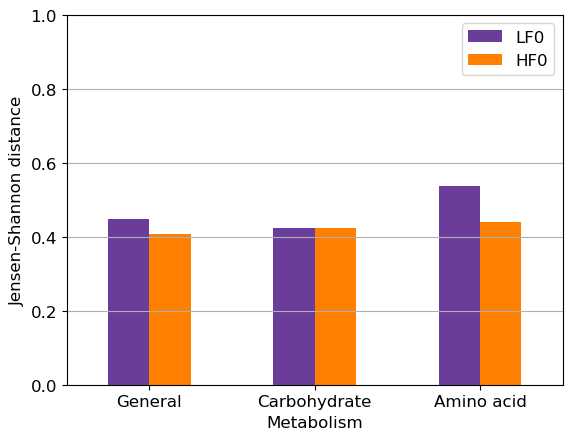

In [11]:
js_table.plot(kind='bar', rot=0, color=[cm.Paired(9), cm.Paired(7)])
plt.ylim(0, 1)
plt.ylabel('Jensen-Shannon distance')
plt.xlabel('Metabolism')
plt.grid(axis='y')
plt.savefig('JS_distance.svg', bbox_inches='tight')
plt.savefig('JS_distance.png', bbox_inches='tight')
plt.show()

In [12]:
js_lf0_reveco = jensenshannon(shift_to_positive(eco_lf0.values).flatten(), hadamard.values.flatten())
js_hf0_reveco= jensenshannon(shift_to_positive(eco_hf0.values).flatten(), hadamard.values.flatten())

print('Jensen-Shannon divergence for LF0 dataset focusing on general metabolism: ', js_lf0_reveco)
print('Jensen-Shannon divergence for HF0 dataset focusing on general metabolism: ', js_hf0_reveco)

Jensen-Shannon divergence for LF0 dataset focusing on general metabolism:  0.42259174838145985
Jensen-Shannon divergence for HF0 dataset focusing on general metabolism:  0.4641116889586624


In [13]:
js_table = pd.DataFrame({'LF0':[js_lf0_reveco], 'HF0':[js_hf0_reveco]}, index=['RevEco'])

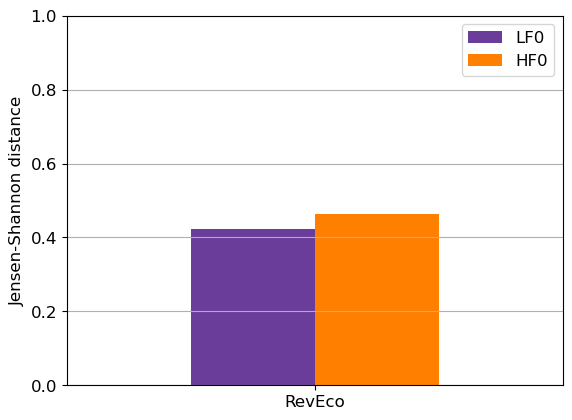

In [14]:
js_table.plot(kind='bar', rot=0, color=[cm.Paired(9), cm.Paired(7)])
plt.ylim(0, 1)
plt.ylabel('Jensen-Shannon distance')
# plt.xlabel('Metabolism')
plt.grid(axis='y')
plt.show()

In [15]:
jensenshannon(metabo_ECs_int_lf_carbo.values.flatten(), metabo_ECs_int_lf.values.flatten())

0.11376849561582414